# Threshold for classification
For the the reversed condition we also try to find threshold for classification (classifying wether a matrix is singular or not).
Here we use and updated version of the threshold for non-uniqiueness.

In [4]:
import numpy as np
from numpy.linalg import matrix_rank, svd
import sys
sys.path.append('../')
from test_data import experiment_data,add_noise,create_data_2d
import pysindy as ps
import matplotlib.pyplot as plt
from error_bounds import *

### Reversed condition $\frac{\sigma_n}{\sigma_1}$: Threshold

If a matrix $A$ is **singular** ($\sigma_n=0$) we have
$$ \frac{\tilde{\sigma}_n}{\tilde{\sigma}_1} \leq \frac{\sigma_n+\epsilon}{\sigma_1-\epsilon} \leq \frac{\epsilon}{C-\epsilon}$$
for $C\leq \sigma_1$ and $\epsilon \geq \|E\|_F$.<br>
If a matrix $A$ is **non singular** ($\sigma_n>0$) we have
$$\frac{\tilde{\sigma}_n}{\tilde{\sigma}_1} \geq \frac{\sigma_n-\epsilon}{\sigma_1+\epsilon} \geq \frac{C_2-\epsilon}{C_1+\epsilon}$$
for $C_2 \leq\sigma_n,  \sigma_1 \leq C_1$

In [5]:
"""
This function should upper bound the reversed condition for singular matrices 
where on>C2>0
 C1:  lower bound of biggest singular value: C <= o_max
 eps: lower bound for frobenius norm of error matrix |E|_F <= eps
"""
def upper_bound_singular_matrix(C,eps):
    if C-eps<=0:
        print(f"Error is too big C<eps with C = {C:.3e}, eps = {eps:.3e}: no upper bound can be calculated")
        return 1.0
    bound= eps/(C-eps)
    bound = min(bound, 1.0) # o_min/o_max <= 1 in all cases
    return bound

"""
This function should lower bound the reversed condition for nonsingular matrices 
where on>C2>0
C1: upper bound for o1 < C1
C2: lower bound for on > C2 > 0
eps: lower obund for frobenius norm of error matrix |E|_F <= eps
The question is how to choose C2?-> boils down to the original problem
"""
def lower_bound_nonsingular_matrix(C1,C2,eps):
    bound= (C2-eps)/(C1+eps)
    bound = max(bound,1e-10)
    return bound

In [6]:
rows,cols = 10,3 #let rows be more than columns
min_value,max_value = -1,2
matrix = np.random.uniform(min_value, max_value, size=(rows, cols))
# Set col 2 equal to col 1
alpha = np.random.rand()
print(alpha)
#matrix[:,0] = alpha*matrix[:,2]
print(matrix)
sv = svd(matrix, compute_uv=False)
sv_max,sv_min = sv[0],sv[-1]
print(f"matrix shape: {matrix.shape}, rank: {matrix_rank(matrix)}" )
print(f"Singular values : {sv}" )
print(f"Smallest/Biggest singular value: {sv[-1]/sv[0]}")

0.857466579448303
[[-0.72315467  0.70598619 -0.382788  ]
 [-0.01089552  0.8310928   1.00876794]
 [-0.05748813  0.45449595  1.74353781]
 [ 1.07794325  0.22550466 -0.4569606 ]
 [-0.39359685 -0.20344262 -0.73978336]
 [ 1.07590544 -0.25945149  1.02333903]
 [-0.07923739  1.44759591 -0.48058881]
 [ 1.71733489 -0.04908366  1.81100006]
 [-0.27304616  1.6926589   0.86190748]
 [-0.24490906  0.26861219  0.01171225]]
matrix shape: (10, 3), rank: 3
Singular values : [3.57933361 2.73412036 1.62953048]
Smallest/Biggest singular value: 0.4552608551766882


In [10]:
# C values for second threshold
C=sv_max #<=sv_max
C1=sv_max#9 #>=sv_max
C2=1e-2#<=sv_min

In [11]:
noise_levels = [10**(-10+i) for i in range(0,9)]
print("Noise level \t ratio \t \t Upper bound \t Lower bound")
ratios =[]
upper_bounds =[]
lower_bounds =[]
for target_noise in noise_levels:
    var = target_noise * np.sqrt(np.mean(np.square(matrix)))
    noise = np.random.normal(0, var, size=matrix.shape)
    matrix_noise = matrix+noise
    sv = svd(matrix_noise, compute_uv=False)
    ratio = sv[-1]/sv[0]
    # Do an educated guess for C and C1
    #C=sv[0] -np.linalg.norm(noise) 
    #C2=sv[-1] + np.linalg.norm(noise) 
    
    ratios.append(ratio)
    upper_bound = upper_bound_singular_matrix(C,np.linalg.norm(noise))
    upper_bounds.append(upper_bound)
    lower_bound = lower_bound_nonsingular_matrix(C1,C2,np.linalg.norm(noise))
    lower_bounds.append(lower_bound)
    print(f" {target_noise}\t \t {ratio:3.3e}  \t {upper_bound:3.3e} \t {lower_bound:3.3e}")

Noise level 	 ratio 	 	 Upper bound 	 Lower bound
 1e-10	 	 4.553e-01  	 1.218e-10 	 2.794e-03
 1e-09	 	 4.553e-01  	 1.331e-09 	 2.794e-03
 1e-08	 	 4.553e-01  	 1.370e-08 	 2.794e-03
 1e-07	 	 4.553e-01  	 1.529e-07 	 2.794e-03
 1e-06	 	 4.553e-01  	 1.313e-06 	 2.792e-03
 1e-05	 	 4.553e-01  	 1.244e-05 	 2.781e-03
 0.0001	 	 4.552e-01  	 1.424e-04 	 2.651e-03
 0.001	 	 4.554e-01  	 1.095e-03 	 1.698e-03
 0.01	 	 4.538e-01  	 1.025e-02 	 1.000e-10


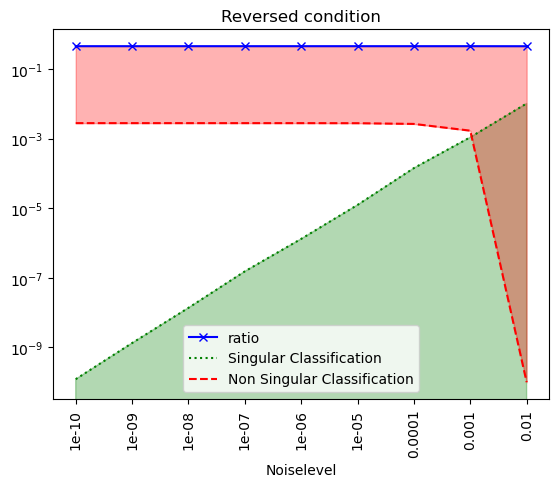

In [12]:
plt.title("Reversed condition")
plt.plot(ratios,marker='x',label="ratio",color='blue')
plt.plot(upper_bounds,':',label="Singular Classification",color='green')
plt.plot(lower_bounds,'--',label="Non Singular Classification",color='red')
plt.fill_between(np.arange(len(noise_levels)), upper_bounds,color='green', alpha=0.3)
plt.fill_between(np.arange(len(noise_levels)), lower_bounds, y2=np.max(ratios), color='red', alpha=0.3)
plt.xticks(np.arange(len(noise_levels)),noise_levels,rotation=90)
plt.yscale('log')
plt.xlabel('Noiselevel')
plt.legend()

### Reversed Condition: Threshold on concrete data

Denote the singular value of $\tilde{G}=G+E$ by  $\tilde{\sigma}_n$ where $G=(u|u_x)$. Furthermore, let $E \geq \|G-\tilde{G}\|_F$.

If the PDE is **non unique**, then $G$ is singular ($\sigma_n=0$) and we have
$$ \frac{\tilde{\sigma}_n}{\tilde{\sigma}_1} \leq \frac{E}{C-E}$$
for $C\leq \sigma_1$.

If the PDE is **unique**, then $G$ is non singular ($\sigma_n>0$) and we have
$$\frac{\tilde{\sigma}_n}{\tilde{\sigma}_1} \geq \frac{\sigma_n-E}{\sigma_1+E} \geq \frac{C_2-E}{C_1+E}$$
for $0 <C_2 \leq \sigma_n,  \sigma_1 \leq C_1$. Note we need to have a valid approximation for a reasonable choice for $C_2$.

Note, here $E$ is the upper bound on the error caused by finite differences
$$E = \sqrt{ m(C_m \frac{\|u-\tilde{u}\|_{\infty}}{h} + h^{order} M C_a)^2 + \|u-\tilde{u}\|_2^2 }$$
However, since in practice we won't know all of these constands we can buest guess $E$ by guessing the maximal error $\epsilon \geq \|u-\tilde{u}\|_{\infty}$ and choosing
$$E =\frac{\epsilon}{h} + h^{order} $$

In [13]:
"""Threshold if values are beneath classify as non unique PDE
E: upper bound on the frobenius  |g-g_noise|_frobenius <=E where g =(u|u_x|...)
C: lower bound of biggest singular value: C <= o_max
"""
def calc_threshold_nonuniq(E,C):
    T = upper_bound_singular_matrix(C,E)
    return T
"""Threshold if values are above classify as unique PDE
E: upper bound on the frobenius  |g-g_noise|_frobenius <=E where g =(u|u_x|...)
C1: upper bound of biggest singular value: C1 => o_max
C2: upper bound of biggest singular value: C2 <= o_max
"""
def calc_threshold_uniq(C1,C2,E):
    T = lower_bound_nonsingular_matrix(C1,C2,E)
    return T

In [14]:
n_samples=100
T,X,t,x = create_data_2d(T_start=0, T_end=1, L_x_start=-2,L_x_end=3, N_t=n_samples, N_x=n_samples)
a=np.random.randn()*1e-6
b=np.random.randn()*1e-3
C=0.1
"""
u = np.cos(X-a*T)*C
ux = -np.sin(X-a*T)*C
uxx = -np.cos(X-a*T)*C
uxxx = np.sin(X-a*T)*C
ut = a*np.sin(X-a*T)*C


u=(X+b*T)*np.exp(a*T)
ux = np.exp(a*T)
uxx= 1
uxxx= 0
ut= b*np.exp(a*T) + a*(X*+b*T)*np.exp(a*T) #bux + aut
"""

u = np.exp(X-a*T)
ux = u
uxx = u
uxxx = u
ut = -a*u

dx=x[1]-x[0]

In [15]:
u_flat, ux_flat = u.flatten(), ux.flatten()
true_g = np.concatenate([u_flat.reshape(len(u_flat),1), ux_flat.reshape(len(ux_flat),1)], axis=1)
sv = svd(true_g, compute_uv=False)
sv_max,sv_min=sv[0],sv[-1]
print(f"M: {np.max(u)}")
print(f"Singular values of g: {sv_max,sv_min}")
print(f"sv_max/sv_min: {sv_min/sv_max:3.3e}")

M: 20.085536923187668
Singular values of g: (916.3927102591995, 1.6492871046870059e-13)
sv_max/sv_min: 1.800e-16


In [16]:
# Choose C,C1,C2
C=sv_max #<=sv_max
C1=sv_max+4 #>=sv_max
C2=1e-02#<=sv_min -> Essentially this boils down to the original problem  of knowing when sv_min is too small to classify the PDE as unique
print(f"For Non-Uniquness: \t \t C = {C:.3e} <= {sv_max:.3e} = sv_max")
print(f"For Uniqueness: \t C1 = {C1:.3e} >= {sv_max:.3e} = sv_max")
print(f"\t \t \t C2 = {C2:.3e} <= {sv_min:.3e} = sv_min")

For Non-Uniquness: 	 	 C = 9.164e+02 <= 9.164e+02 = sv_max
For Uniqueness: 	 C1 = 9.204e+02 >= 9.164e+02 = sv_max
	 	 	 C2 = 1.000e-02 <= 1.649e-13 = sv_min


0.0
order 	 singular values 	 ratio 	 Threshold uniq 	 Threshold non-uniq 
1 	 [926.01154677   6.75033854] 	 7.290e-03 	 1.000e-10 	 1.844e-02
3 	 [9.16387692e+02 3.99734103e-03] 	 4.362e-06 	 1.007e-06 	 9.901e-06
5 	 [9.1639271e+02 7.4857658e-06] 	 8.169e-09 	 1.085e-05 	 1.155e-08
7 	 [9.16392710e+02 1.21671443e-08] 	 1.328e-11 	 1.086e-05 	 1.998e-11
9 	 [9.16392710e+02 6.30190423e-11] 	 6.877e-14 	 1.086e-05 	 1.008e-13


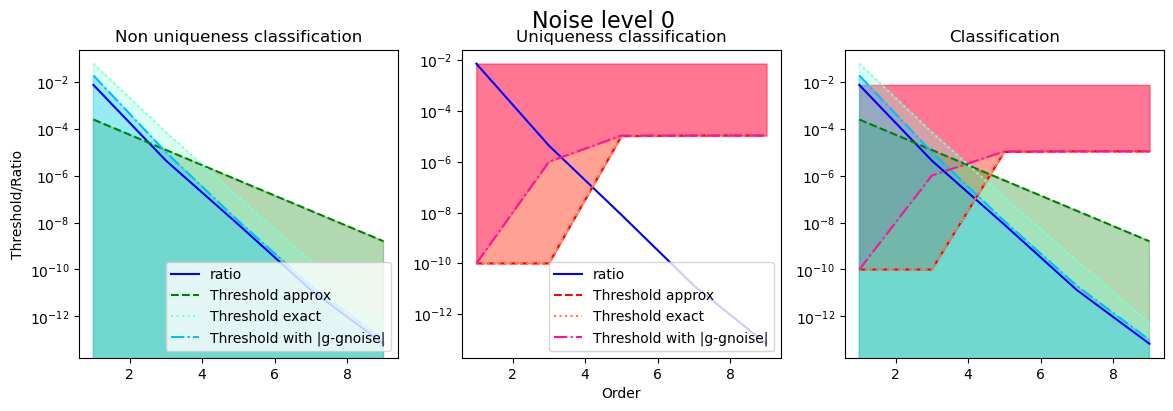

6.491872393729578e-08
order 	 singular values 	 ratio 	 Threshold uniq 	 Threshold non-uniq 
1 	 [926.01154676   6.75033855] 	 7.290e-03 	 1.000e-10 	 1.844e-02
3 	 [9.16387692e+02 3.99736120e-03] 	 4.362e-06 	 1.007e-06 	 9.901e-06
5 	 [9.16392710e+02 7.64848416e-06] 	 8.346e-09 	 1.085e-05 	 1.180e-08
7 	 [9.16392710e+02 2.71107998e-06] 	 2.958e-09 	 1.086e-05 	 4.179e-09
9 	 [9.16392710e+02 7.05045778e-06] 	 7.694e-09 	 1.085e-05 	 1.088e-08


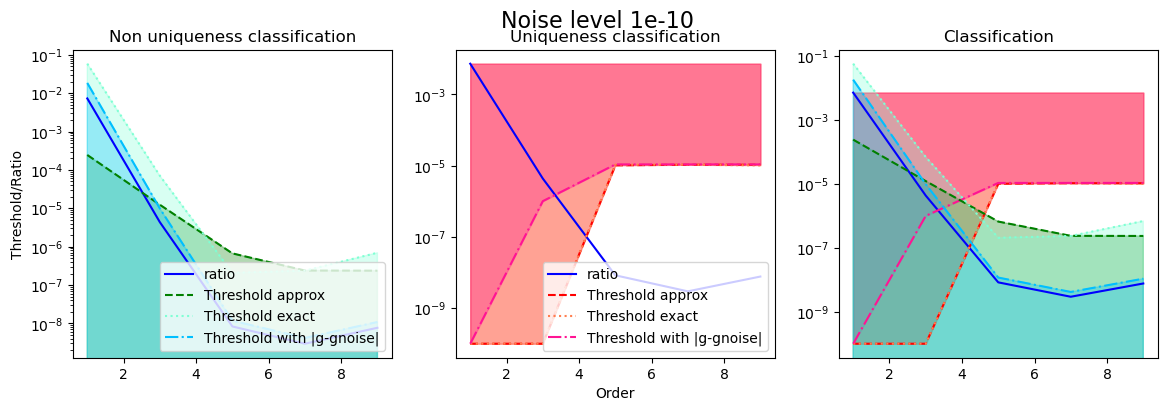

6.50868765801519e-07
order 	 singular values 	 ratio 	 Threshold uniq 	 Threshold non-uniq 
1 	 [926.01154684   6.75033851] 	 7.290e-03 	 1.000e-10 	 1.844e-02
3 	 [9.16387692e+02 3.99761503e-03] 	 4.362e-06 	 1.007e-06 	 9.901e-06
5 	 [9.16392710e+02 1.75995089e-05] 	 1.921e-08 	 1.084e-05 	 2.704e-08
7 	 [9.16392710e+02 2.90811846e-05] 	 3.173e-08 	 1.082e-05 	 4.483e-08
9 	 [9.16392711e+02 7.02986570e-05] 	 7.671e-08 	 1.076e-05 	 1.085e-07


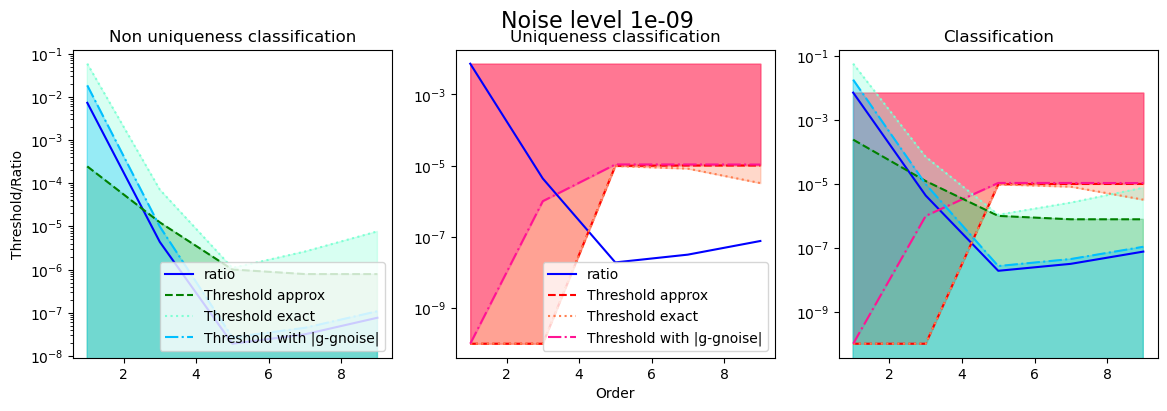

6.366597587754459e-06
order 	 singular values 	 ratio 	 Threshold uniq 	 Threshold non-uniq 
1 	 [926.01154663   6.75033908] 	 7.290e-03 	 1.000e-10 	 1.844e-02
3 	 [9.16387692e+02 3.99897992e-03] 	 4.364e-06 	 1.005e-06 	 9.903e-06
5 	 [9.16392710e+02 1.59841949e-04] 	 1.744e-07 	 1.062e-05 	 2.455e-07
7 	 [9.16392708e+02 2.85774035e-04] 	 3.118e-07 	 1.043e-05 	 4.406e-07
9 	 [9.16392701e+02 7.10550207e-04] 	 7.754e-07 	 9.773e-06 	 1.097e-06


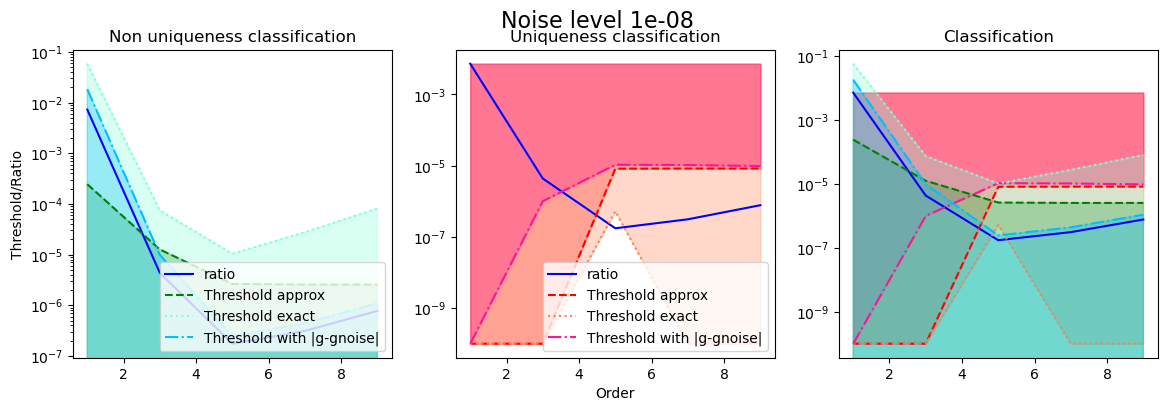

6.447344920787106e-05
order 	 singular values 	 ratio 	 Threshold uniq 	 Threshold non-uniq 
1 	 [926.01154523   6.75033348] 	 7.290e-03 	 1.000e-10 	 1.844e-02
3 	 [9.16387696e+02 4.13001500e-03] 	 4.507e-06 	 8.881e-07 	 1.002e-05
5 	 [9.16392724e+02 1.51620850e-03] 	 1.655e-06 	 8.548e-06 	 2.327e-06
7 	 [9.16392705e+02 2.73771832e-03] 	 2.987e-06 	 6.663e-06 	 4.220e-06
9 	 [9.16392543e+02 6.83987698e-03] 	 7.464e-06 	 3.534e-07 	 1.056e-05


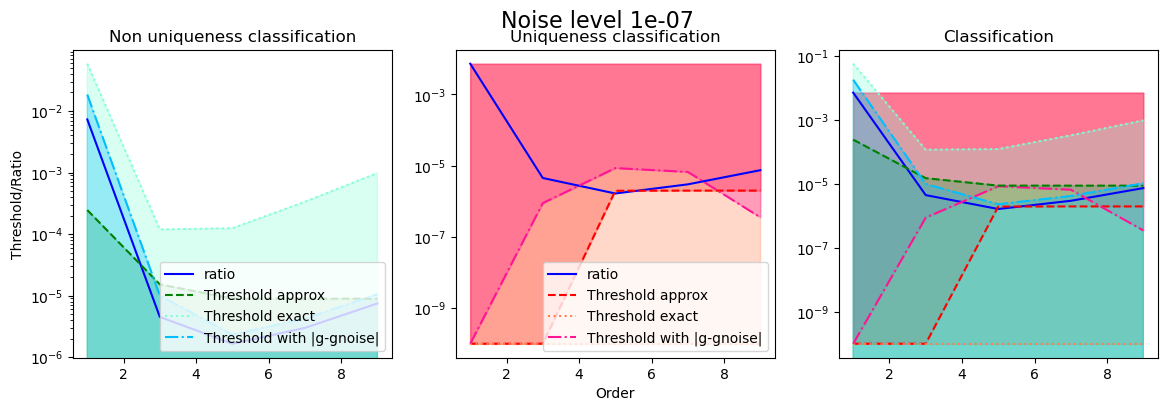

0.0006429052459038212
order 	 singular values 	 ratio 	 Threshold uniq 	 Threshold non-uniq 
1 	 [926.01159564   6.75021987] 	 7.290e-03 	 1.000e-10 	 1.844e-02
3 	 [9.16387768e+02 1.23957069e-02] 	 1.353e-05 	 1.000e-10 	 2.037e-05
5 	 [9.16392859e+02 1.59803562e-02] 	 1.744e-05 	 1.000e-10 	 2.455e-05
7 	 [9.16392858e+02 3.07213915e-02] 	 3.352e-05 	 1.000e-10 	 4.738e-05
9 	 [9.16392472e+02 7.53547327e-02] 	 8.223e-05 	 1.000e-10 	 1.163e-04


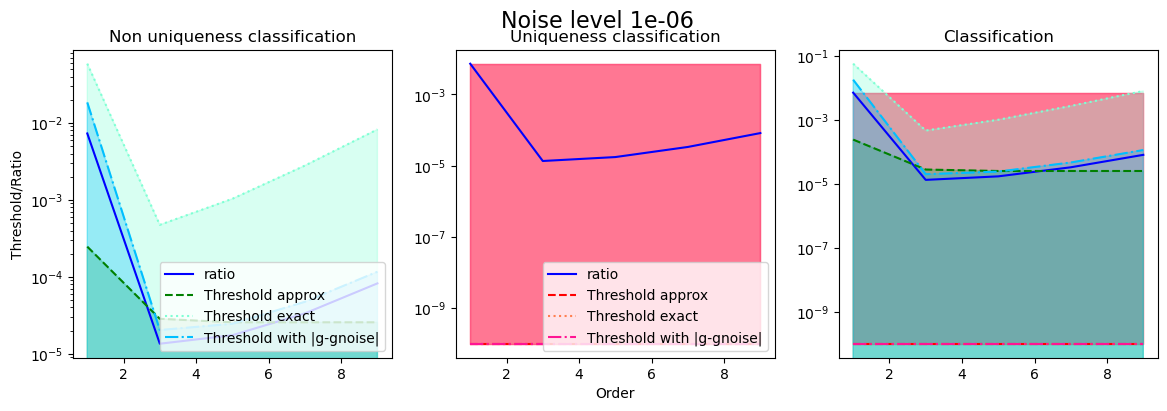

0.006474306428842625
order 	 singular values 	 ratio 	 Threshold uniq 	 Threshold non-uniq 
1 	 [926.01251041   6.74937892] 	 7.289e-03 	 1.000e-10 	 1.844e-02
3 	 [9.16389215e+02 1.17930423e-01] 	 1.287e-04 	 1.000e-10 	 1.794e-04
5 	 [9.16395952e+02 1.53138725e-01] 	 1.671e-04 	 1.000e-10 	 2.351e-04
7 	 [9.16397084e+02 2.88482750e-01] 	 3.148e-04 	 1.000e-10 	 4.450e-04
9 	 [9.16396023e+02 7.35384028e-01] 	 8.025e-04 	 1.000e-10 	 1.136e-03


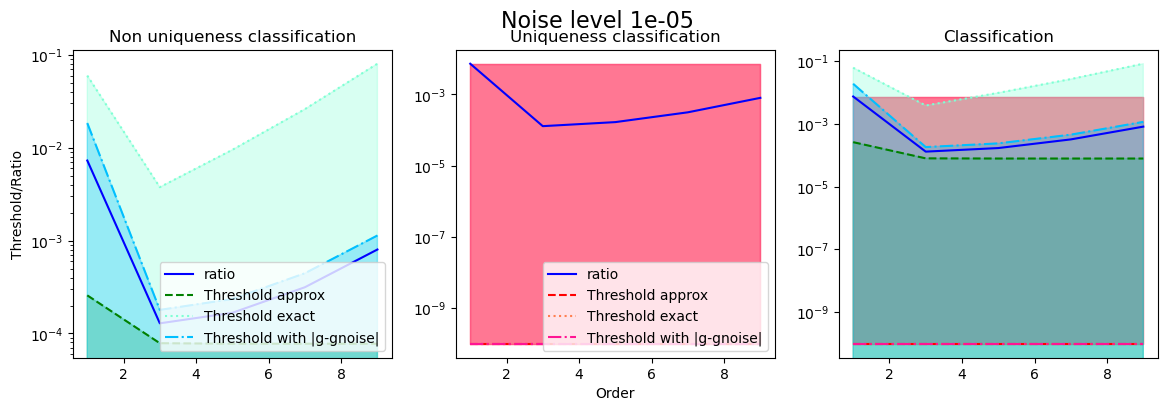

0.06414441794705682
order 	 singular values 	 ratio 	 Threshold uniq 	 Threshold non-uniq 
1 	 [926.00957349   6.88024389] 	 7.430e-03 	 1.000e-10 	 1.855e-02
3 	 [916.3787881    1.16432531] 	 1.271e-03 	 1.000e-10 	 1.774e-03
5 	 [916.36362479   1.484336  ] 	 1.620e-03 	 1.000e-10 	 2.283e-03
7 	 [916.33533456   2.68522369] 	 2.930e-03 	 1.000e-10 	 4.157e-03
9 	 [916.27351448   6.68739875] 	 7.298e-03 	 1.000e-10 	 1.043e-02


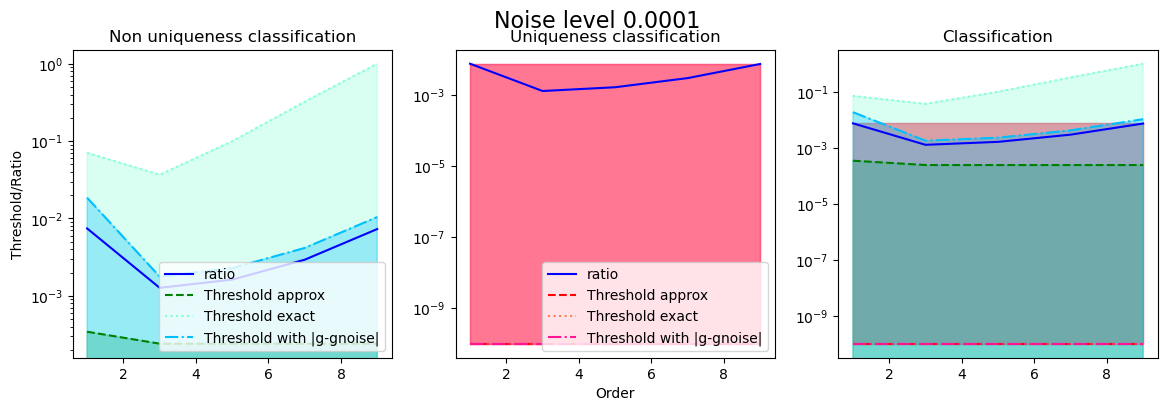

0.6539926376361239
order 	 singular values 	 ratio 	 Threshold uniq 	 Threshold non-uniq 
1 	 [925.9851024   14.92965769] 	 1.612e-02 	 1.000e-10 	 2.784e-02
3 	 [916.31331625  11.9683728 ] 	 1.306e-02 	 1.000e-10 	 1.854e-02
Error is too big C<eps with C = 9.164e+02, eps = 9.541e+02: no upper bound can be calculated
5 	 [916.37286061  15.35455632] 	 1.676e-02 	 1.000e-10 	 2.414e-02
Error is too big C<eps with C = 9.164e+02, eps = 2.573e+03: no upper bound can be calculated
7 	 [917.26141165  27.78875147] 	 3.030e-02 	 1.000e-10 	 4.480e-02
Error is too big C<eps with C = 9.164e+02, eps = 7.542e+03: no upper bound can be calculated
9 	 [921.75601369  71.17956164] 	 7.722e-02 	 1.000e-10 	 1.243e-01


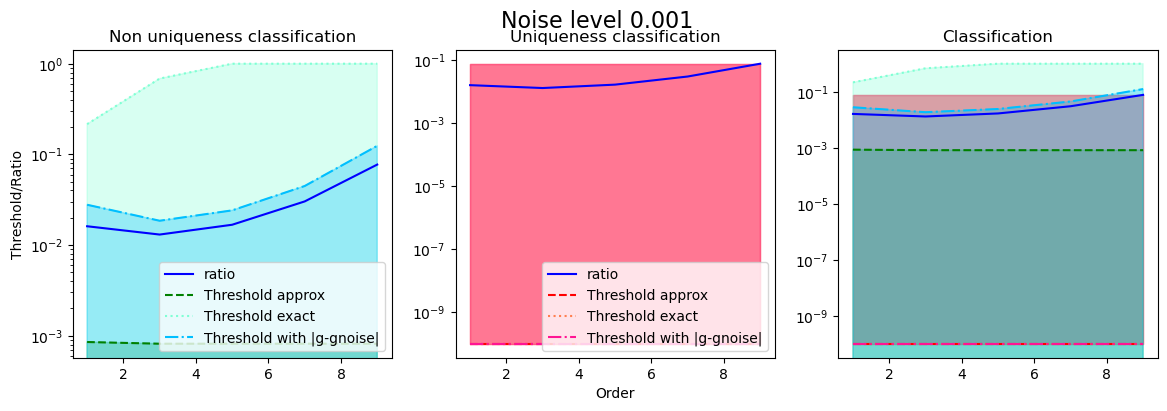

In [24]:
M=infinity_norm(uxxx)
number_noise=9 #<=10
noise_levels = [0]+[10**(-10+i) for i in range(0,number_noise-1)]
orders=range(1,10,2)
unorm2=np.sqrt(np.mean(np.square(u)))

for target_noise in noise_levels:    
    threshold_uniq_list = []
    threshold2_uniq_list = []
    threshold3_uniq_list = []
    threshold_nonunique_list = []
    threshold2_nonunique_list = []
    threshold3_nonunique_list = []
    ratio_list=[]
    
    var = target_noise * unorm2
    noise = np.random.normal(0, var, size=u.shape)
    print(np.linalg.norm(noise))
    u_noise = u + noise
    eps_two = np.linalg.norm(u-u_noise)
    eps_infty = infinity_norm(u-u_noise)
    print(f"order \t singular values \t ratio \t Threshold uniq \t Threshold non-uniq ")
    for order in orders:        
        ux_noise = ps.FiniteDifference(order=order,d=1, axis=0, drop_endpoints=False)._differentiate(u_noise, dx)
        u_flat_noise, u_x_flat_noise = u_noise.flatten(), ux_noise.flatten()
        g_noise = np.concatenate([u_flat_noise.reshape(len(u_flat_noise),1), u_x_flat_noise.reshape(len(u_flat_noise),1)], axis=1)
        sv = svd(g_noise, compute_uv=False)
        
        
        ratio=sv[-1]/sv[0]

        #Potential upper bounds for |G-G_noise| 
        E1=np.sqrt(eps_infty/dx+dx**order)
        E2 = np.sqrt(error_bound_g(eps_two,eps_infty,dx,true_g.shape[0],M,order))
        E3 = np.linalg.norm(true_g-g_noise)
        
        threshold_uniq =  calc_threshold_uniq(C1,C2,E1)
        threshold2_uniq =  calc_threshold_uniq(C1,C2,E2)
        threshold3_uniq =  calc_threshold_uniq(C1,C2,E3)
        threshold_uniq_list.append(threshold_uniq)
        threshold2_uniq_list.append(threshold2_uniq)
        threshold3_uniq_list.append(threshold3_uniq)

  
        threshold_nonunique = calc_threshold_nonuniq(E1,C)
        threshold2_nonunique = calc_threshold_nonuniq(E2,C)
        threshold3_nonunique = calc_threshold_nonuniq(E3,C)
        threshold_nonunique_list.append(threshold_nonunique)
        threshold2_nonunique_list.append(threshold2_nonunique)
        threshold3_nonunique_list.append(threshold3_nonunique)
        
        print(f"{order} \t {sv} \t {ratio:.3e} \t {threshold3_uniq:.3e} \t {threshold3_nonunique:.3e}")
        ratio_list.append(ratio)

    # Create subplots
    fig, ax = plt.subplots(1, 3, sharex=True, figsize=(14, 4))
    fig.suptitle(f'Noise level {target_noise}', fontsize=16)
    
    # Subplot 1: ratio and green lines
    ax1.set_title("Non uniqueness classification")
    ax1.plot(orders, ratio_list, label='ratio', color='blue')
    ax1.plot(orders, threshold_nonunique_list, '--', label='Threshold approx', color='green')
    ax1.plot(orders, threshold2_nonunique_list, ':', label='Threshold exact', color='aquamarine')
    ax1.plot(orders, threshold3_nonunique_list, '-.', label='Threshold with |g-gnoise|', color='deepskyblue')
    ax1.fill_between(orders, threshold_nonunique_list, color='green', alpha=0.3)
    ax1.fill_between(orders, threshold2_nonunique_list, color='aquamarine', alpha=0.3)
    ax1.fill_between(orders, threshold3_nonunique_list, color='deepskyblue', alpha=0.3)
    ax1.set_yscale('log')
    ax1.set_ylabel('Threshold/Ratio')
    
    # Subplot 2: ratio and red lines
    ax2.set_title("Uniqueness classification")
    ax2.plot(orders, ratio_list, label='ratio', color='blue')
    ax2.plot(orders, threshold_uniq_list, '--', label='Threshold approx', color='red')
    ax2.plot(orders, threshold2_uniq_list, ':', label='Threshold exact', color='coral')
    ax2.plot(orders, threshold3_uniq_list, '-.', label='Threshold with |g-gnoise|', color='deeppink')
    ax2.fill_between(orders, threshold_uniq_list, y2=np.max(ratio_list), color='red', alpha=0.3)
    ax2.fill_between(orders, threshold2_uniq_list, y2=np.max(ratio_list), color='coral', alpha=0.3)
    ax2.fill_between(orders, threshold3_uniq_list, y2=np.max(ratio_list), color='deeppink', alpha=0.3)
    ax2.set_yscale('log')

    ax3.set_title("Classification")
    ax3.plot(orders, ratio_list, label='ratio', color='blue')
    ax3.plot(orders, threshold_uniq_list, '--', label='Threshold approx', color='red')
    ax3.plot(orders, threshold2_uniq_list, ':', label='Threshold exact', color='coral')
    ax3.plot(orders, threshold3_uniq_list, '-.', label='Threshold with |g-gnoise|', color='deeppink')
    ax3.plot(orders, threshold_nonunique_list, '--', label='Threshold approx', color='green')
    ax3.plot(orders, threshold2_nonunique_list, ':', label='Threshold exact', color='aquamarine')
    ax3.plot(orders, threshold3_nonunique_list, '-.', label='Threshold with |g-gnoise|', color='deepskyblue')
             
    ax3.fill_between(orders, threshold_uniq_list, y2=np.max(ratio_list), color='red', alpha=0.3)
    ax3.fill_between(orders, threshold2_uniq_list, y2=np.max(ratio_list), color='coral', alpha=0.3)
    ax3.fill_between(orders, threshold3_uniq_list, y2=np.max(ratio_list), color='deeppink', alpha=0.3)
             
    ax3.fill_between(orders, threshold_nonunique_list, color='green', alpha=0.3)
    ax3.fill_between(orders, threshold2_nonunique_list, color='aquamarine', alpha=0.3)
    ax3.fill_between(orders, threshold3_nonunique_list, color='deepskyblue', alpha=0.3)
    ax3.set_yscale('log')

    
    ax2.set_xlabel('Order')
    ax1.legend(loc=4)
    ax2.legend(loc=4)
    
    plt.show()
    